# A tiny CNN

a convolutional neural network is a specific kind of deep neural network especially suited for computer vision and image processing. It is a type of feedforward neural network (inputs multiplied by weights to obtain outputs) that learns features via kernel optimization. CNN's were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. 

A convolutional neural network consists of an input layer, hidden layers, and an output layer. The hidden layers include one or more layers that perform convolutions. A convolution is the application of a sliding window function (filter or kernel) to a matrix of pixels representing an image. In the convolution layer, several filters of equal size are applied, and each filter is used to recognize a specific pattern from the image, such as edges, curves etc. Another type of hidden layer is the activation layer and the pooling layer, which reduces the dimension of the feature map by computing the most significant features (e.g. maxpooling extracts the max feature in the kernel window). The layers of a CNN thus normally consist of combinations of convolution, activation, and pooling layers. The last layer(s) of a CNN consist of fully connected layers, with their inputs corresponding to the flattened one-dimensional feature matrix generated by the last pooliong layer.

## import required libraries

In [5]:
import os
import sys
import torch
from torchinfo import summary

module_path = os.path.abspath(os.path.join('..')) # project root
# add project root to sys.path
if module_path not in sys.path:
    sys.path.append(module_path) 
from src.data_loader import get_dataloader
from src.transforms import get_train_transforms, get_val_transforms
from src.models import tinycnn
from src.train import train_model
from src.evaluate import evaluate_model
from src.plot_metrics import plot_learningcurve, plot_confusionmatrix


## Configuration
Set hyperparameters and device for training. Use GPU if available, otherwise use the CPU

In [6]:
data_dir = "../data/raw/chest_xray"
batch_size = 32
epochs = 10
learning_rate = 0.001
img_size = 224 # make smaller for faster CPU training
n_channels = 1 

# get device for training
#device  = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"


## Load data

In [7]:
# set num_workers to 0, safer on Windows with CPU
train_transform = get_train_transforms(img_size,augment=False)
val_transform = get_val_transforms(img_size)
train_dataloader = get_dataloader(os.path.join(data_dir,'train'), batch_size=batch_size, num_workers=0,transform=train_transform)
val_dataloader = get_dataloader(os.path.join(data_dir,'val'), batch_size=batch_size, num_workers=0,transform=val_transform)
test_dataloader = get_dataloader(os.path.join(data_dir,'test'), batch_size=batch_size, num_workers=0,transform=val_transform)

## Model setup
### Create instance of TinyCNN model 

In [8]:
model = tinycnn.get_tinycnn(img_size,n_channels,use_batchnorm=False,use_dropout=False).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# print the model summary
summary(model,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
TinyCNN                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 32, 56, 56]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─ReLU: 3-2                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-3               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 32, 112, 112]        4,640
│    │    └─ReLU: 3-5                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-6               [32, 32, 56, 56]          --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Flatten: 2-3                      [32, 100352]              --
│    └─Linear: 2-4                       [32, 64]                  6,422,592
│   

### loss function
During training, we need a measure to determine the performance of the model. This is measure is called a loss-function, which measures the degree of dissimilarity between the obtained result and the target value. The loss function is minimized during training. For binary problems (two classes) a commonly used Loss function is the "Binary Cross Entropy Loss". In Pytorch, we will use the "BCEWithLogitsLoss" loss function. A loss function called "BCELoss" also exists but BCEWithLogitsLoss is numerically more stable, and it applies the sigmoid function internally, which BCELoss does not (so then it should be applied in the forward function).

In [9]:
loss_function = torch.nn.BCEWithLogitsLoss()

### Optimizer
During the training process, the weights of the model are updated according to the loss function. How much the weights are changed is important as we don't want to overshoot the mimimum of the loss function, but also do not want to change them too slow otherwise the optimization will take a long time. Here we choose the Adam optimizer, which is a popular adaptive optmizer algorithm. The optimizer is initialized by registering the model's parameters that need to be trained and passing the learning rate hyperparameter.

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train the model
The model is trained by looping over the epochs. The training loop iterates over the training dataset and tries to converge to optimal parameters. Inside the training loop, optimization happens in three steps:
- Call optimizer.zero_grad() to reset the gradients of model prameters.
- Backpropagate the prediction loss with a call to loss.backward(). 
- call optimizer.step() to adjust the parameters by the gradients collected during the backward propagation.
At the end of each epoch, the validation dataset is evaluated to check if model performance is improving.

In [11]:
train_metrics_history = train_model(model,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs,scheduler=None)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [03:25<00:00,  1.26s/it]


  Average train loss:0.190391  
 Accuracy on the train dataset: 92.98%


Validation: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


  Average val loss:0.750895  
 Accuracy on the validation dataset: 75.96%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [02:32<00:00,  1.07it/s]


  Average train loss:0.073129  
 Accuracy on the train dataset: 97.14%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


  Average val loss:0.722907  
 Accuracy on the validation dataset: 81.73%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [02:32<00:00,  1.07it/s]


  Average train loss:0.052077  
 Accuracy on the train dataset: 98.06%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


  Average val loss:0.947790  
 Accuracy on the validation dataset: 77.56%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [02:32<00:00,  1.07it/s]


  Average train loss:0.036367  
 Accuracy on the train dataset: 98.89%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


  Average val loss:1.217193  
 Accuracy on the validation dataset: 79.49%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [02:38<00:00,  1.03it/s]


  Average train loss:0.028441  
 Accuracy on the train dataset: 99.00%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


  Average val loss:1.956098  
 Accuracy on the validation dataset: 73.56%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [02:40<00:00,  1.02it/s]


  Average train loss:0.013074  
 Accuracy on the train dataset: 99.46%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


  Average val loss:2.086288  
 Accuracy on the validation dataset: 72.44%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [02:38<00:00,  1.03it/s]


  Average train loss:0.010741  
 Accuracy on the train dataset: 99.65%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


  Average val loss:1.797713  
 Accuracy on the validation dataset: 76.12%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [02:35<00:00,  1.05it/s]


  Average train loss:0.009916  
 Accuracy on the train dataset: 99.71%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


  Average val loss:1.960515  
 Accuracy on the validation dataset: 74.36%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [02:40<00:00,  1.01it/s]


  Average train loss:0.005294  
 Accuracy on the train dataset: 99.85%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


  Average val loss:2.886719  
 Accuracy on the validation dataset: 73.88%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [02:48<00:00,  1.04s/it]


  Average train loss:0.000934  
 Accuracy on the train dataset: 100.00%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

  Average val loss:2.864248  
 Accuracy on the validation dataset: 74.68%
Done!


## Save the model

In [12]:
torch.save(model,'../models/tinycnn_10ep.pth')

## Results


### Learning curve

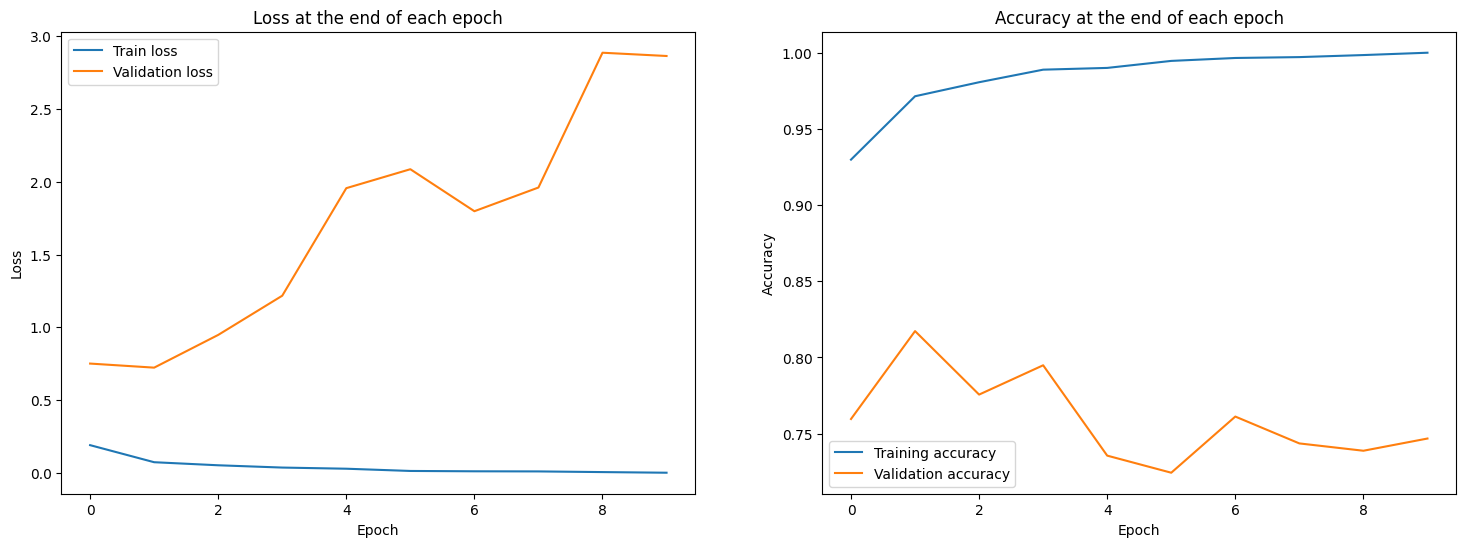

In [13]:
# plot the evolution of the losses and accuracy over the epochs
plot_learningcurve(train_metrics_history)


### Precision, recall and F1 score
The F1 score is a harmonic mean of precision and recall. It is useful for evaluating models when there is class imbalance, as it provides a more balanced measure of the model's performance. The F1 score ranges from 0 (worst) to 1 (best).

In [14]:
metrics = evaluate_model(model, test_dataloader, loss_function, device="cpu")
# Compute precision, recall, F1 score, and AUC
print(f"Accuracy on the test set: {metrics['accuracy']:.2%}")
print(f"Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1 score: {metrics['f1']:.2f}, AUC: {metrics['auc']:.2f}")

print(f"classification report: {metrics['classification report']}")


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]

Accuracy on the test set: 74.68%
Precision: 0.71, Recall: 0.99, F1 score: 0.83, AUC: 0.66
classification report:               precision    recall  f1-score   support

           0       0.97      0.33      0.50       234
           1       0.71      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.75      0.71       624



### Confusion Matrix
A confusion matrix is a table that describes the performance of a classification model on a set of test data for which the true labels are known. It helps with identifying misclassifications and better understand model's performance. The confusion matrix displays the number of true positives, true negatives, false positives and false negatives for each class. 

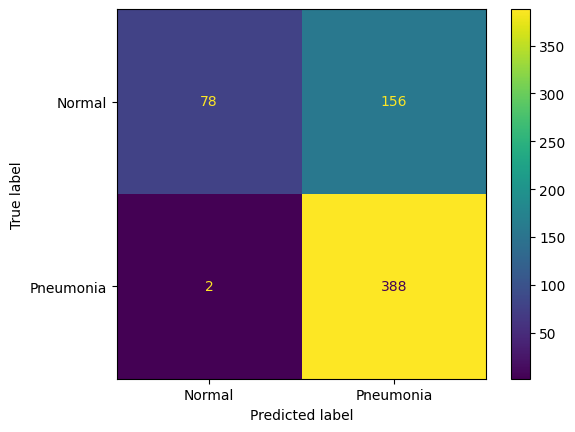

In [15]:
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(metrics['confusion matrix'])

## Conclusion
- The tiny CNN reached an accuracy of 74% on the provided validation set
- The learning curve shows that the accuracy on the training set is much higher (around 99%). as the number of epochs increase, the accuracy of the training set increases while the accuracy of the validation set decreases. This indicates the model is overfitting the training data. The model becomes too specialized to the training data while it fails to generalize well to unseen data.
- F1 score is 0.82, AUC is 0.65
- The confusion matrix shows that the model has a high sensitivity (Recall) for the Pneumonia class.For the Normal class, the precision is lower. The model incorrectly classifies a significant number of the normal cases as pneumonia. The model seems to be indentifying the Pneumonia cases better than the normal cases, which could be due to the imbalance in the dataset. 

## Possible improvements
